In [1]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D


2024-12-03 03:05:56.936403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 03:05:57.046704: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 03:05:57.052000: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/n

# Importing and Visualizing Data
Data is downloaded to home directory. 

Using Kaggle instead

In [2]:
# !pip install kagglehub
# This one takes 3 minutes
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/mulugetah/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2


In [3]:
import numpy as np
import os
import pandas as pd

# Loading data into the memory is not efficient since it doesn't have enough memory for that much data
# Load filenames into dataframe instead

images = []

labels = []

label_count = 0

images_path = path + r"/images/Images/"

for label in os.listdir(images_path):
    label_path = images_path + label + "/"
    label_count += 1
    for file in os.listdir(label_path):
        images.append(label_path + file)
        labels.append(label.split('-')[1])

df = pd.DataFrame({"image_path" : images, "label": labels})


df = df[:1500:]
df.shape

(1500, 2)

In [4]:
X_train, X_temp = train_test_split(df, test_size=0.2, stratify=df["label"], random_state = 42)

label_test_val = X_temp['label']

# 10%.   10%
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (1200, 2)
The shape of test data (150, 2)
The shape of validation data (150, 2)


In [5]:
# parameters
image_size = 255 # Size of the image
image_channel = 3 # Colour scale (RGB)
bat_size = 32 # Number of files/images processed at once

In [6]:
# Applyingimage data gernerator to train and test data
datagen = ImageDataGenerator(
            validation_split=0.2,
            rescale=1./255, # to bring the image range from 0..255 to 0..1
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0, # randomly zoom image 
            width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False) # randomly flip images

train_generator = datagen.flow_from_dataframe(X_train,
                                                    x_col= 'image_path',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size),
                                                    class_mode="categorical",
                                                   )
val_generator = datagen.flow_from_dataframe(X_val, 
                                                 x_col= 'image_path',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False,
                                                 class_mode="categorical",
                                                )

test_generator = datagen.flow_from_dataframe(X_test, 
                                                  x_col= 'image_path',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                 )

Found 1200 validated image filenames belonging to 8 classes.
Found 150 validated image filenames belonging to 8 classes.
Found 150 validated image filenames belonging to 8 classes.


In [7]:
num_classes = len(train_generator.class_indices)
num_classes

8

In [8]:
plt.figure(figsize=(10,8))
#Plots our figures
for i in range(1,5):
  plt.subplot(1, 4, i)
  batch = next(test_generator)
  image_ = batch[0][0]
  plt.imshow(image_)
plt.show()

# Using Classical Machine Learning
We will be using KMeans in order to try to classify the dog breeds. It probably won't perform well. 

As a start, we should pick the least well classified breeds and try to get the best scores we can before moving to DNN and CNNs. The image shows the best accuracies achieved in each breed. We will be trying to get the best in the bottom, say 5. 

![image](bar_graph_full.png)

In [9]:
batch = next(train_generator)[0]
batch.shape


(32, 255, 255, 3)

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=16)

In [11]:
%%time
def generator_to_reduced_array(generator):
    images = []
    labels = []
    for batch in generator:
        image = batch[0]
        label = batch[1]
        if isinstance(image, np.ndarray):
            print(f"Batch shape before flattening: {image.shape}")
            flat_batch = image.reshape(image.shape[0], -1)
            print(f"Batch shape after flattening: {flat_batch.shape}")

            reduced_batch = pca.fit_transform(flat_batch)
            print(f"Reduced batch shape: {reduced_batch.shape}")
            images.extend(reduced_batch)
            labels.extend(label)

        if len(images) * generator.batch_size >= generator.samples:
            break
    images = np.vstack(images)
    
    return images, labels

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


In [12]:
images, _ = generator_to_reduced_array(train_generator)

Batch shape before flattening: (32, 255, 255, 3)
Batch shape after flattening: (32, 195075)
Reduced batch shape: (32, 16)
Batch shape before flattening: (32, 255, 255, 3)
Batch shape after flattening: (32, 195075)
Reduced batch shape: (32, 16)


In [13]:
images.shape

(64, 16)

In [14]:
kmeans = KMeans(n_clusters=num_classes)  
kmeans.fit(images)
cluster_labels = kmeans.labels_

In [15]:
img_size = (image_size, image_size, image_channel)
centers_in_original_space = pca.inverse_transform(kmeans.cluster_centers_)
centers_images = centers_in_original_space.reshape(num_classes, *img_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6201048..1.5897299].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.053833693..0.8590758].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3955921..0.95426023].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32012627..1.6164056].


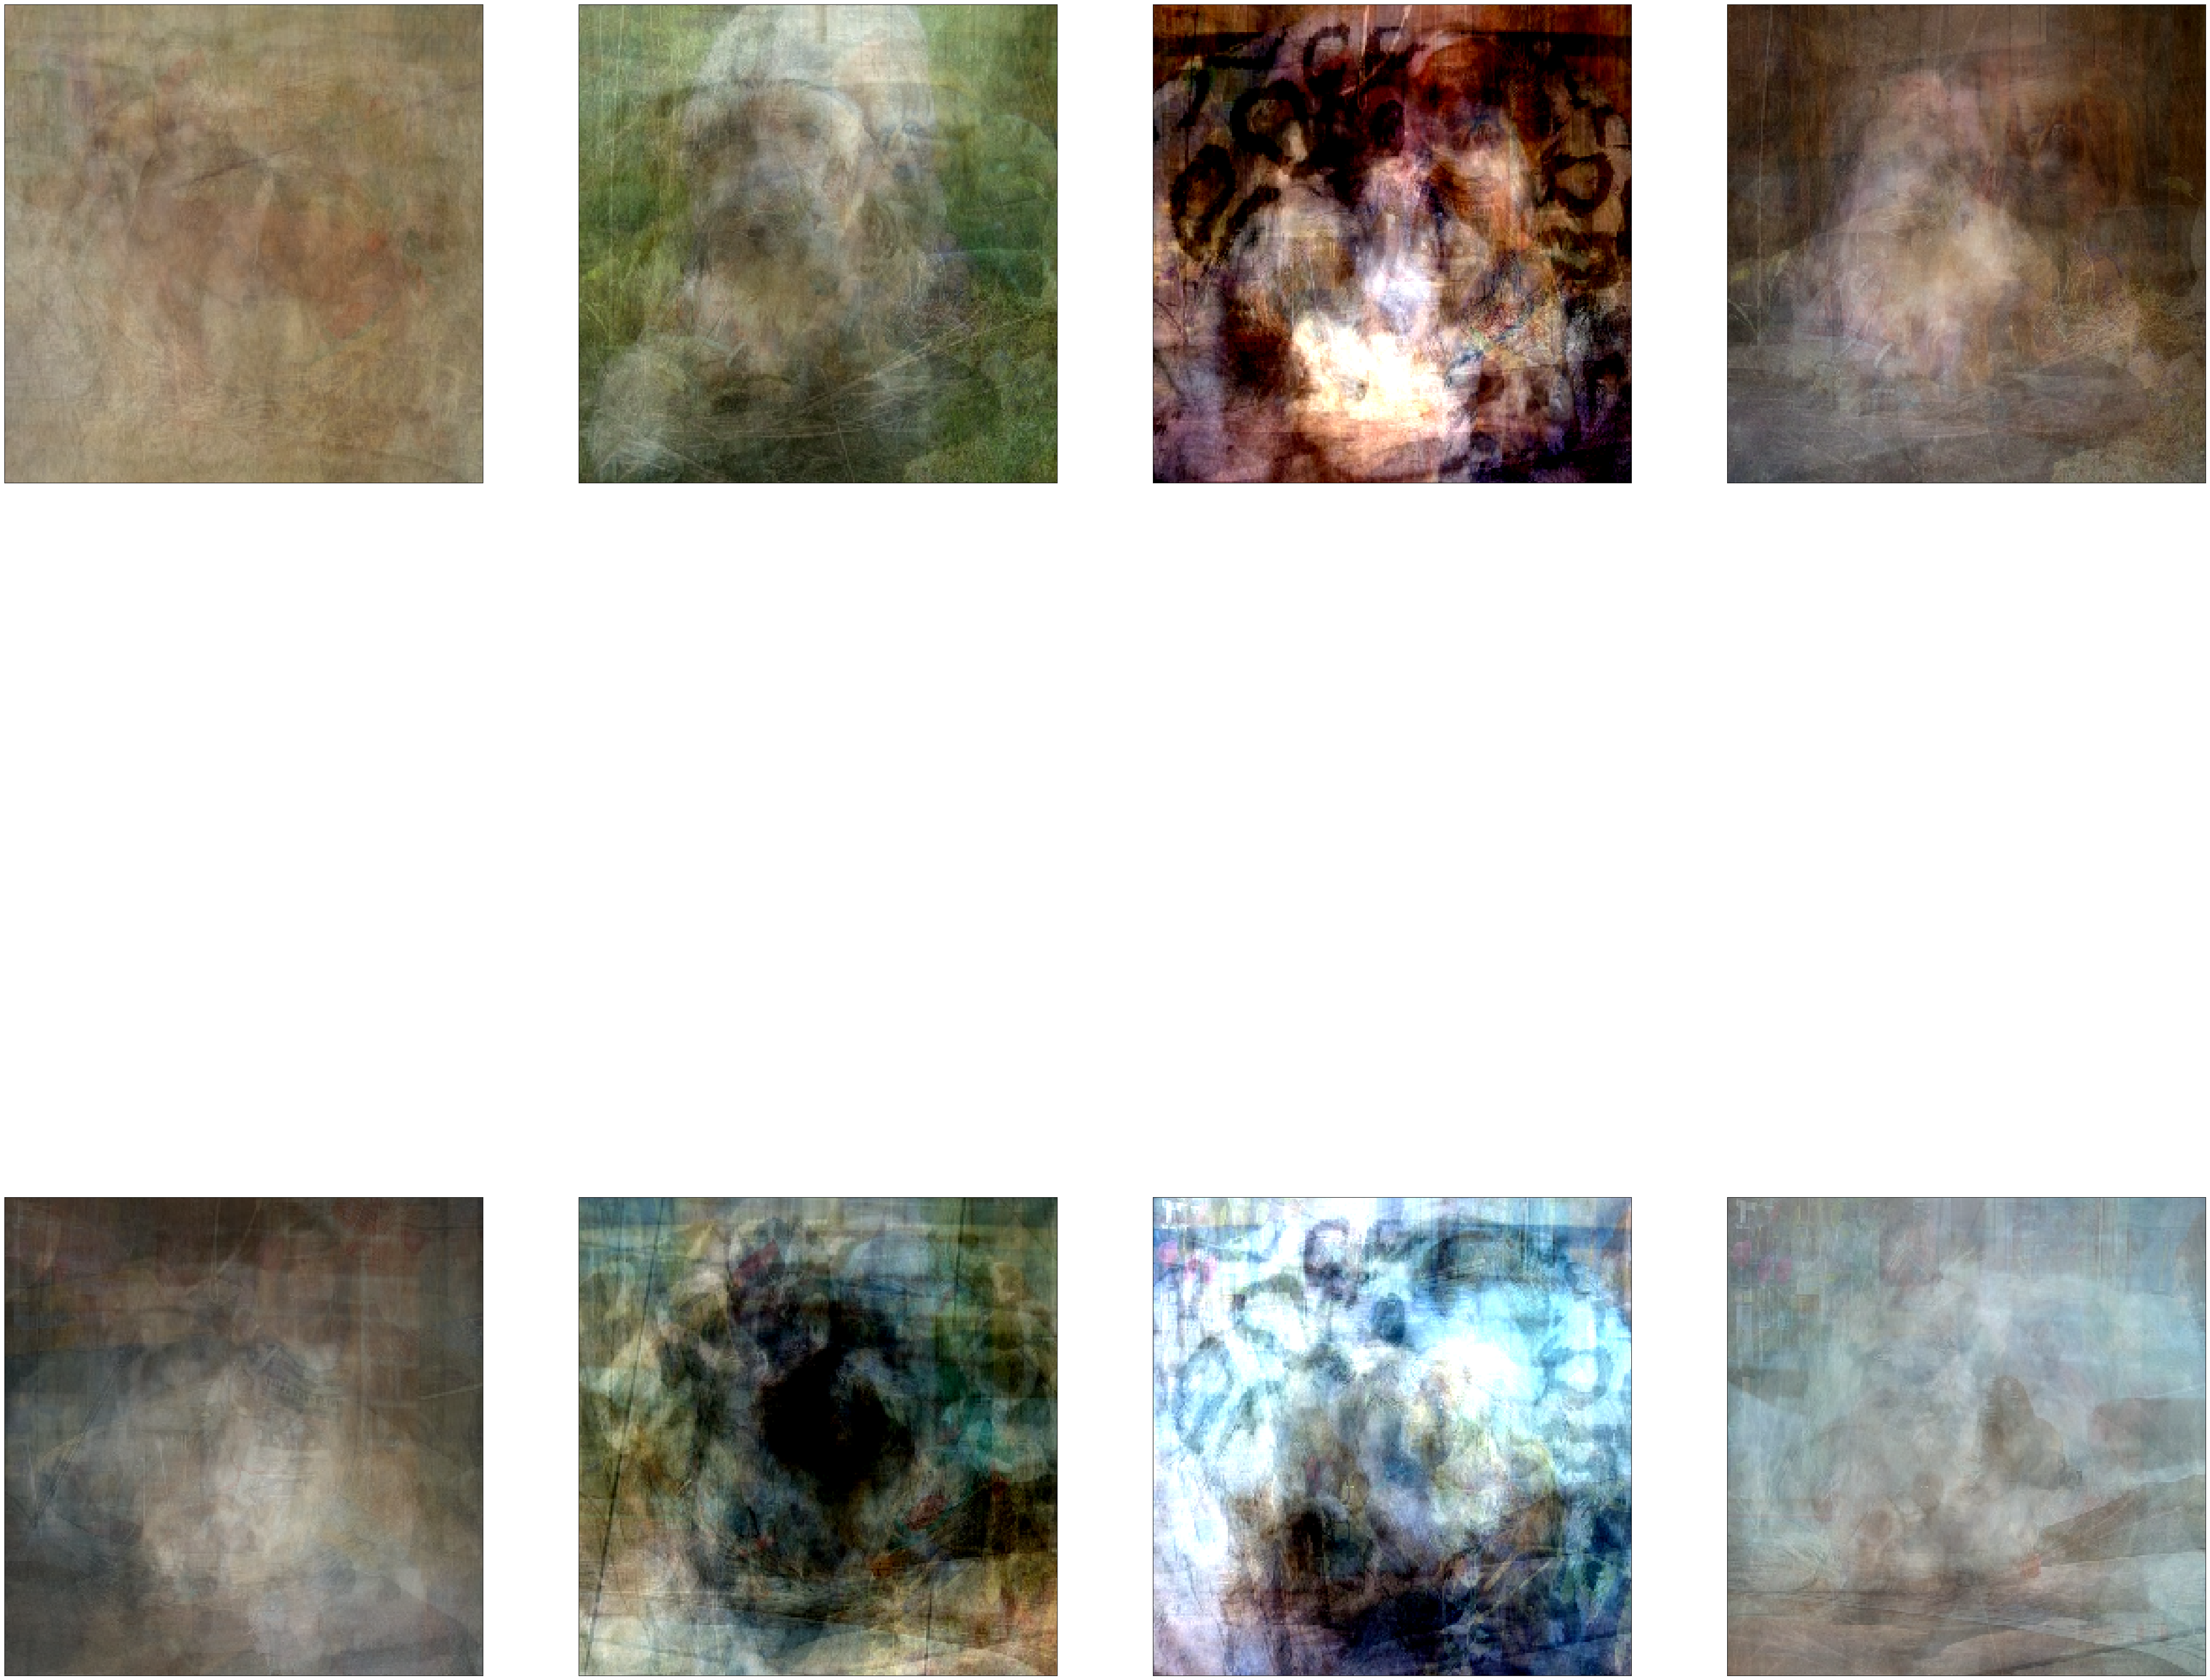

In [24]:
fig, ax = plt.subplots(2, 4, figsize=(64, 64))
for axi, center in zip(ax.flat, centers_images):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [17]:
test_images, true_labels = generator_to_reduced_array(test_generator)
predicted_labels = kmeans.predict(test_images)

Batch shape before flattening: (22, 255, 255, 3)
Batch shape after flattening: (22, 195075)
Reduced batch shape: (22, 16)


In [18]:
from sklearn.metrics import accuracy_score
dehot_coded_labels = np.argmax(true_labels, axis=1) + 1
print(accuracy_score(dehot_coded_labels, predicted_labels))
list(zip(dehot_coded_labels, predicted_labels))

0.09090909090909091


[(7, 5),
 (3, 0),
 (1, 0),
 (3, 3),
 (3, 4),
 (1, 7),
 (3, 4),
 (4, 4),
 (6, 1),
 (2, 3),
 (6, 3),
 (2, 7),
 (2, 3),
 (8, 7),
 (2, 4),
 (1, 4),
 (3, 7),
 (6, 4),
 (3, 0),
 (2, 7),
 (7, 1),
 (7, 5)]

# CNN
Everything after this is specific to Convolutional Nueral Networks but you can try to look at how it is set up.

In [19]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 1 
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


# Fully Connected layers 
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(num_classes,activation='softmax')) # Softmax for binary classification

model.summary()

2024-12-03 03:06:13.769508: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-03 03:06:13.769555: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: dh-node13
2024-12-03 03:06:13.769563: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: dh-node13
2024-12-03 03:06:13.769743: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: INVALID_ARGUMENT: expected %d.%d, %d.%d.%d, or %d.%d.%d.%d form for driver version; got "1"
2024-12-03 03:06:13.769768: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 555.42.2
2024-12-03 03:06:13.770217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 253, 253, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 126, 126, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 124, 124, 64)     2

In [20]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [21]:
train_generator.target_size

(255, 255)

In [22]:
fitted = model.fit(train_generator,
                    validation_data = val_generator, 
                    epochs = 3,
                    # steps_per_epoch = len(train_generator),
                    # validation_steps = len(val_generaotor),
                   )

Epoch 1/3
38/38 [==============================] - 23s 569ms/step - loss: 0.8622 - accuracy: 0.1858 - val_loss: 0.5669 - val_accuracy: 0.1867
Epoch 2/3
38/38 [==============================] - 21s 558ms/step - loss: 0.5224 - accuracy: 0.3883 - val_loss: 0.5171 - val_accuracy: 0.1600
Epoch 3/3
38/38 [==============================] - 21s 554ms/step - loss: 0.3876 - accuracy: 0.4842 - val_loss: 0.5059 - val_accuracy: 0.1667


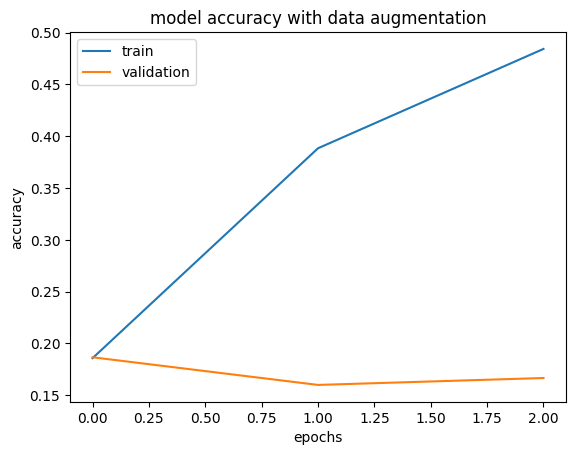

In [23]:
history = model.history

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('model accuracy with data augmentation')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()